# Deep learning using Lasagne in Nengo

Lasagne is a popular deep learning package.  It uses Theano as the underlying computational framework, but provides a higher level syntax to make it easier to construct neural networks.  The `nengo_lasagne` package is a backend for Nengo that compiles a Nengo network into a Lasagne implementation.  The network can then be trained using any of Lasagne's built-in optimization methods, or any other training scheme implemented in Theano.

From the user's perspective, constructing a network looks the same as any other Nengo model.  There are a few additional limitations (so the set of possible `nengo_lasagne` models is a subset of the overall space of Nengo models).  Some of these are due to features that I just haven't implemented yet, some may never be implemented (certain network structures are just not amenable to deep learning optimization, and it seems better to just be upfront about that rather than trying to shoe-horn them in).

In [1]:
%matplotlib inline

import pickle

import lasagne
import matplotlib.pyplot as plt
import nengo # note: requires the `nengo_lasagne_compat` branch currently
import nengo_lasagne
import numpy as np
import theano

from lasagne import nonlinearities as nl
from nengo.processes import PresentInput

theano.config.floatX = "float32"

/Users/celiasmi/Library/Python/2.7/lib/python/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


We need to define the overall inputs and outputs for the network, which will drive the training. The inputs and outputs should be 3D arrays, with shape `(batch_size, sequence_length, input d)` and `(batch_size, sequence_length, output d)` respectively (input and output `d` do not have to be the same). This means that we're going to be processing `d` dimensional inputs and outputs, and processing `batch_size` vectors at a time. The `sequence_length` dimension defines the inputs that will be presented at each timestep (so each timestep will process one `(batch_size, d)` set of inputs).

Note that if there are no recurrent connections in the model then the sequential presentation of inputs makes no difference (since there is no internal state persisting between timesteps).  So in those cases the `batch_size` and `sequence_length` dimensions will be flattened (effectively processing all the timesteps at once).  But to keep things simple the inputs and outputs are still always specified as 3D arrays.

In this example, we are splitting the overall input into 3 one dimensional inputs, though it would be possible to do the same thing with one 3 dimensional input.

In [2]:
# in this demo we'll just use uniform random inputs
# we could just create one 3D node, but we'll use 3 1D
# nodes for demonstration purposes, resulting in a 4D array.
inputs = np.random.uniform(-1, 1, size=(3, 1000, 1, 1)).astype(np.float32)

# an arbitrary output function
def target_func(inputs):
    return (inputs[0] + 1) * inputs[1] ** 2 + np.sin(inputs[2])
outputs = target_func(inputs)

Now we can build the network itself.  `nengo_lasagne.default_config()` specifies a set of defaults that are useful for constructing these kinds of networks (used to override the standard Nengo defaults).  Specifically, this removes synaptic filtering, sets all biases to be the same (zero), limits the initial range of gains (0.9-1.1) and sets the default neuron to be a rectified linear unit (ReLU).

In [3]:
print(nengo_lasagne.default_config())

Parameters configured for Connection:
  synapse: None
Parameters configured for Ensemble:
  bias: Choice(options=array([ 0.]))
  gain: Uniform(low=0.9, high=1.1)
  neuron_type: RectifiedLinear()


In [4]:
with nengo.Network() as net, nengo_lasagne.default_config():
    # create nodes to define the input for the network (the same as
    # any other nengo model). note that the output of these nodes is 
    # just used when running the network, not during the training 
    # process (during training we'll use the input array defined above,
    # since we're not training online)
    # here we'll use the PresentInput process to feed in the inputs we
    # defined above, one at a time. 
    input_nodes = [nengo.Node(output=PresentInput(x.squeeze(axis=1), 0.001))
                   for x in inputs]

    # create ensembles 
    ens0 = nengo.Ensemble(100, 2)
    ens1 = nengo.Ensemble(50, 1)
    
    # create connections (note that slicing works in the same
    # way as default nengo)
    nengo.Connection(input_nodes[0], ens0[0])
    nengo.Connection(input_nodes[1], ens0[1])
    nengo.Connection(input_nodes[2], ens1)

    # network output
    output_node = nengo.Node(size_in=1)
    
    # we can specify a function/transform on a connection. these
    # will be used to initialize the weights (using the standard
    # NEF nengo solvers)
    nengo.Connection(ens0, output_node,
                     function=lambda x: (x[0] + 1) * x[1] ** 2)
    nengo.Connection(ens1, output_node, function=np.sin)

    # add probes to nodes or neurons to collect their output
    p = nengo.Probe(output_node)

This network looks like:
<img src="3Dnetwork.png" width=400>

To access the `nengo_lasagne` backend we just pass the network we constructed to `nengo_lasagne.Simulator`. This will build  a Lasagne network with the same structure as the Nengo network defined above.  The weights in this network are untrained (set to whatever initial values are defined in the Nengo network).  If we run the untrained network we can see the initial performance.

The probed output will be stored in the `sim.data` dictionary, as in standard Nengo.  Note that the probed outputs will have the same shape as described above, `(batch_size, sequence_len, d)`.  Batch size is just 1 when we run it this way, but we'll see an example where batch size is >1 later on.

In [5]:
sim = nengo_lasagne.Simulator(net)

sim.run_steps(1000)

# example target/actual outputs
print(outputs[:3])
print(sim.data[p][:, :3])

# root mean squared error
print(np.sqrt(np.mean(outputs - sim.data[p]) ** 2))

checking network
building network
[[[ 0.422203  ]]

 [[ 0.76344299]]

 [[ 0.23597831]]]
[[[ 0.53315175]
  [ 0.85680389]
  [ 0.35134622]]]
0.0384067296982


To train the network we call the `train` function on the constructed model.  The first parameter is a dict that maps `nengo.Nodes` to the input arrays we defined above (so the backend knows where to insert those inputs in the network).  The second parameter does the same for the targets.  `n_epochs` defines how many times the training process will iterate through the training data, and `minibatch_size` defines the size of the minibatches used within an epoch (once through the dataset). Typically the batch size will be the size of the entire data set, whereas the minibatch size will be a subsample of that data used per update during training.  `optimizer` specifies one of the 
optimization methods defined in `lasagne.updates` (or this could be any Theano optimizer that implements the same interface).  The `optimizer_kwargs` will be passed to the optimizer function (in this case this is setting the learning rate).

In [6]:
sim.model.train(dict(zip(input_nodes, inputs)), {output_node: outputs},
                n_epochs=1000, minibatch_size=100, 
                optimizer=lasagne.updates.adagrad,
                optimizer_kwargs={"learning_rate": 1e-2})

training network
Simulation finished in 0:00:05.                                                 
training complete


Now we can run the trained network:

In [7]:
sim.run_steps(1000)

print(outputs[:3])
print(sim.data[p][:, :3])

print(np.sqrt(np.mean(outputs - sim.data[p]) ** 2))

[[[ 0.422203  ]]

 [[ 0.76344299]]

 [[ 0.23597831]]]
[[[ 0.43956223]
  [ 0.75437605]
  [ 0.23053226]]]
0.000272936274996


You'll notice that we get a pretty small error after training. For comparison, we can run the same network with the reference simulator:

In [8]:
sim = nengo.Simulator(net)
sim.run_steps(1000)

print(outputs[:3])
print(sim.data[p][None, :3])

print(np.sqrt(np.mean(outputs - sim.data[p][None, ...]) ** 2))

Simulation finished in 0:00:01.                                                 
[[[ 0.422203  ]]

 [[ 0.76344299]]

 [[ 0.23597831]]]
[[[ 0.85368089]
  [ 0.37356134]
  [ 1.01460264]]]
0.031002271685


## Recurrent networks

Recurrent networks work in exactly the same way. One new feature being demonstrated here is the option to pass a distribution for the transform parameter.  This will cause the initial weights to be sampled from that distribution.  Any of the distributions in `nengo.dists` can be used, or any of the distributions in `lasagne.init` (access them via `nengo_lasagne.init` to wrap them in a Nengo distribution).

Here we're implementing a 1D integrator:

checking network
building network
training network
Simulation finished in 0:00:30.                                                 
training complete


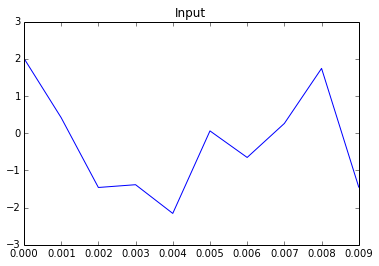

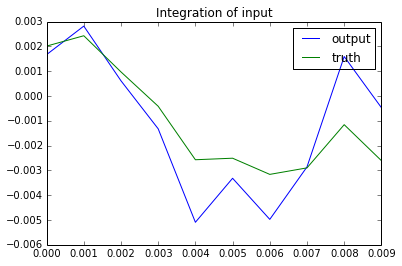

In [10]:
batch_size = 1000
sig_len = 10
dt = 1e-3
inputs = np.random.randn(batch_size, sig_len, 1).astype(np.float32)
targets = np.cumsum(inputs, axis=1) * dt

with nengo.Network() as net, nengo_lasagne.default_config():
    # note that here we're using a different test input than the training input
    input_node = nengo.Node(output=nengo.processes.WhiteNoise(scale=False))
    ens = nengo.Ensemble(50, 1)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    # initialize weights from distribution
    nengo.Connection(ens.neurons, ens.neurons,
                     transform=nengo_lasagne.init.GlorotUniform())
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_lasagne.Simulator(net, dt=dt)
sim.model.train({input_node: inputs}, {output_node: targets},
                n_epochs=1000, minibatch_size=100,
                optimizer_kwargs={"learning_rate": 1e-2})
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=1)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[input_p][0])
plt.title('Input')

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth[0], label="truth")
plt.title('Integration of input')
plt.legend()

When we run the network as above, `nengo_lasagne` generates the inputs by checking the output of the input Nodes.  However, the inputs can also be specified directly by passing a `dict` mapping nodes to input arrays (the same format used when specifying the training inputs).  This can be useful to run a batch of inputs simultaneously:

In [11]:
sim.run_steps(sig_len, {input_node: np.random.randn(batch_size, sig_len, 1).astype(np.float32)})

truth = np.cumsum(sim.data[input_p], axis=1)*dt

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((truth - sim.data[output_p])**2)))

(1000, 10, 1)
0.0015365


As above, we can use the NEF to initialize the weights on the recurrent connection.

checking network
building network
training network
Simulation finished in 0:00:28.                                                 
training complete
(1000, 10, 1)
0.00153751


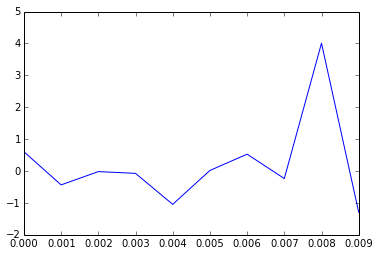

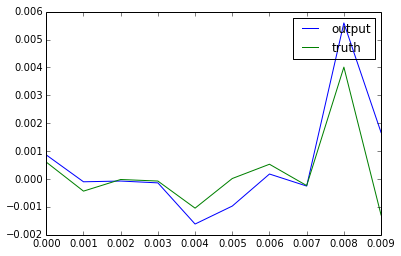

In [11]:
with nengo.Network() as net, nengo_lasagne.default_config():
    # note that here we're using a different test input than the training input
    input_node = nengo.Node(output=nengo.processes.WhiteNoise(scale=False))
    ens = nengo.Ensemble(50, 1)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    nengo.Connection(ens, ens)
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_lasagne.Simulator(net, dt=dt)
sim.model.train({input_node: inputs}, {output_node: targets},
                n_epochs=1000, minibatch_size=100,
                optimizer_kwargs={"learning_rate": 1e-2})
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=0)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[input_p][0])

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth[0], label="truth")
plt.legend()

sim.run_steps(sig_len, {input_node: np.random.randn(batch_size, sig_len, 1).astype(np.float32)})

truth = np.cumsum(sim.data[input_p], axis=1)*dt

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((truth - sim.data[output_p])**2)))

# Inserting Lasagne code directly

Another thing we might want to do is write some code directly in Lasagne, and then insert that into a `nengo`/`nengo_lasagne` model.  To do that, we can use `nengo_lasagne.LasagneNode`.  To start, just create the desired Lasagne network (in this case we'll do a 2D convnet MNIST example):

In [13]:
# load the inputs/targets (download the dataset at
# http://deeplearning.net/data/mnist/mnist.pkl.gz)
with open("mnist.pkl", "rb") as f:
    train, _, test = pickle.load(f)
targets = np.zeros((train[1].shape[0], 1, 10), dtype=np.float32)
targets[np.arange(train[1].shape[0]), :, train[1]] = 1.0

# input layer
l = lasagne.layers.InputLayer(shape=(None,))

# reshape it into the (batch_size, n_channels, 28, 28) image shape
l = lasagne.layers.ReshapeLayer(l, shape=(-1, 1, 28, 28))

# 2 convolution/pooling layers
for _ in range(2):
    l = lasagne.layers.Conv2DLayer(l, num_filters=32, filter_size=(5, 5),
                                   nonlinearity=nl.rectify,
                                   W=lasagne.init.HeNormal(gain="relu"))
    l = lasagne.layers.MaxPool2DLayer(l, pool_size=(2, 2))

# dense layer
l = lasagne.layers.DenseLayer(l, num_units=256, nonlinearity=nl.rectify,
                              W=lasagne.init.HeNormal(gain='relu'))

# dropout
l = lasagne.layers.DropoutLayer(l, p=0.5)

# output layer
l = lasagne.layers.DenseLayer(l, num_units=10, nonlinearity=nl.softmax)

Note that the variable `l` refers to only the most recently constructed layer. However, each layer contains a reference to the previously constructed layer as well, so the entire network can be accessed through `l`.  Next we create a `LasagneNode`, and pass the output layer as the `output` parameter:

In [14]:
with nengo.Network() as net, nengo_lasagne.default_config():
    # 'insert_weights' is an optional config setting we can use
    # to control whether a connection weight matrix is inserted
    # for each connection, or whether we just directly connect
    # the output of the pre to the post. in this case we already
    # created all the weight matrices we want in the above
    # Lasagne network.
    net.config[nengo.Connection].set_param("insert_weights",
                                           nengo.params.BoolParam(False))

    # input node will just present one input image per timestep
    input_node = nengo.Node(output=PresentInput(test[0], 0.001))
    
    # insert the convolutional network we defined above
    conv_layers = nengo_lasagne.layers.LasagneNode(output=l, size_in=784)
    
    # output node
    output_node = nengo.Node(size_in=10)

    nengo.Connection(input_node, conv_layers)
    nengo.Connection(conv_layers, output_node)

    p = nengo.Probe(output_node)

When we build the network, `nengo_lasagne` will compile the contents of the `LasagneNode` directly into the network graph.  This means that we can train the parameters inside the `LasagneNode` in the same way as we did previously:

In [15]:
sim = nengo_lasagne.Simulator(net)

# we'll use a different optimizer function here, nesterov_momentum.
# we'll also use a different objective, categorical_crossentropy,
# as opposed to the default squared error we were using previously.
sim.train({input_node: train[0][:, None]}, {output_node: targets},
          n_epochs=10, minibatch_size=500,
          optimizer=lasagne.updates.nesterov_momentum,
          optimizer_kwargs={"learning_rate": 0.01, "momentum": 0.9},
          objective=lasagne.objectives.categorical_crossentropy)

checking network
building network
training network
Simulation finished in 0:09:20.                                                 
training complete


If we run the trained network, we can see it getting ~98% accuracy on the test set.  Note that we're only training for 10 epochs, which is quite small.  If you have more patience you can change the `n_epochs` parameter above to 100/200, which should get >99% accuracy.

In [16]:
sim.run_steps(test[0].shape[0])

output = sim.data[p].squeeze()

print(np.mean(np.argmax(output, axis=1) == test[1]))

0.9845


But that's not all!  One of the nice things about `LasagneNode` is that it's just a thin wrapper around a regular `nengo.Node`.  That means that we can take the same MNIST network (which contains our trained `LasagneNode`), and build it using reference `nengo` instead:

In [17]:
sim = nengo.Simulator(net)
sim.run_steps(test[0].shape[0])

output = sim.data[p]

print(np.mean(np.argmax(output[:-1], axis=1) == test[1][1:]))

Simulation finished in 0:00:06.                                                 
0.984498449845


And there we go, the same Lasagne network is now running within regular Nengo.